In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 1234

tf.random.set_seed(SEED)
np.random.seed(SEED)
img_w, img_h = 256,256

bs = 8

num_classes= 58
path = '../input/vqadataset/VQA_Dataset/Images'

# Data preprocessing

In train_questions_annotations.json are the annotated data, having the following structure:

>{
>  '1': 
>  {'question': ..., 
>   'image_id': ...,
>   'answer': ...},
>  '2':
>  {'question': ..., 
>   'image_id': ...,
>   'answer': ...},
>  ...
>}


All the possible answers are listed below

In [2]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

Retrieve the dataset as dataframe

In [3]:
dataset_dir = '../input/vqadataset/VQA_Dataset'

with open(os.path.join(dataset_dir,"train_questions_annotations.json")) as f:
    dic = json.load(f)

dataframe = pd.DataFrame(dic.items())
dataframe.rename(columns = {0:'data_id', 1:'data'}, inplace = True)

dataframe.head()

,data_id,data
0,117792,"{'question': 'Who looks happier?', 'image_id':..."
1,117790,"{'question': 'Where is the woman sitting?', 'i..."
2,117791,"{'question': 'Where is the man sitting?', 'ima..."
3,55360,"{'question': 'Is this man hungry?', 'image_id'..."
4,169490,"{'question': 'Who is holding the football?', '..."


In [4]:
data_ = pd.json_normalize(dataframe['data'])
data_.rename(columns = {'image_id':'filename', 'answer':'class'}, inplace = True)

data_['filename'] = data_['filename'].apply(lambda x: str(x)+'.png')
data_['class'] = data_['class'].apply(lambda x: labels_dict[x])
data_.head()

,question,filename,class
0,Who looks happier?,11779.png,31
1,Where is the woman sitting?,11779.png,12
2,Where is the man sitting?,11779.png,8
3,Is this man hungry?,5536.png,57
4,Who is holding the football?,16949.png,31


Removing questions with answer "yes" or "no" from the dataset

In [5]:
data_.drop(data_[(data_["class"] == 33) | (data_["class"] == 57)].index, inplace=True)
data_.head()

,question,filename,class
0,Who looks happier?,11779.png,31
1,Where is the woman sitting?,11779.png,12
2,Where is the man sitting?,11779.png,8
4,Who is holding the football?,16949.png,31
7,What is the predominant color of the room?,3371.png,17


In [7]:
msk = np.random.rand(len(data_)) < 0.8
train_df = data_[msk]
validation_df = data_[~msk]

In [8]:
import re
seqlen = data_['question'].apply(lambda x: len(re.findall(r'[^\w\s]|\w+', x)))
SEQ_LEN = max(seqlen.tolist()) +2 #special tokens start-end

25

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') # everything to lower case

# Custom dataset

In [11]:
from PIL import Image
from tensorflow.keras.utils import to_categorical


class CustomDataset(tf.keras.utils.Sequence):

    def __init__(self, max_len_question, num_classes, tokenizer, filename, question, answer=None, bs=1, preprocessing_function=None, out_shape=[256, 256]):
  
        self.max_len = max_len_question
        self.num_classes = num_classes
        self.tokenizer = tokenizer
        self.subset_filenames = filename
        self.question = np.array(question)
        if answer == None:
            answer = [0 for _ in range(len(filename))]
        self.labels = np.array(answer)
        self.out_shape = out_shape
        self.preprocessing_function = preprocessing_function
        self.bs = bs
        
    def __len__(self):
        return int(np.floor(len(self.subset_filenames) / self.bs))

    def __getitem__(self, index):
    
        # one hot encoding of the anwer
        arr_answ = np.array(self.labels[index:index+self.bs])
        ys = np.zeros((arr_answ.size, self.num_classes))
        ys[np.arange(arr_answ.size), arr_answ] = 1
        
        imgs = []
        
        Xids = np.zeros((self.bs, self.max_len))
        Xmasks = np.zeros((self.bs, self.max_len))
        
        for i in range(self.bs):
            curr_filename = self.subset_filenames[index]
            img = Image.open(os.path.join(path, curr_filename))
        
        
            # Resize image and mask
            img = img.resize(self.out_shape)
            img_arr = np.asarray(img)
            
            # the last dimension is the brightness
            img_arr = img_arr[:,:,:-1]
            
            if self.preprocessing_function is not None:
                img_arr = self.preprocessing_function(img_arr)
            imgs.append(img_arr)
            
            question = self.question[index]

            tokens = self.tokenizer.encode_plus(question, max_length=self.max_len,
                             truncation=False, padding="max_length",
                             add_special_tokens=True, return_token_type_ids=False,
                             return_attention_mask=True, return_tensors='tf')
            
            Xids[i,:], Xmasks[i,:] = tokens['input_ids'], tokens['attention_mask']
           
            index += 1
 
        xs = {}
        xs['input_ids'] = Xids
        xs['attention_mask'] = Xmasks
        xs['images'] = np.array(imgs)
        return xs, ys

# Model structure

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from tensorflow.keras.layers import Flatten 

model_image = Sequential()

input_images = tf.keras.layers.Input(shape=[img_w, img_h, 3], 
                                  name='images',
                                    dtype='int32') 
vgg = tf.keras.applications.VGG16(include_top=False, pooling='avg')
vgg.trainable = False
model_image.add(input_images)
model_image.add(vgg)
model_image.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN, ), 
                                  name='input_ids',
                                 dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN, ), 
                             name='attention_mask',
                                 dtype='int32')

embeddings = bert(input_ids, attention_mask = mask)[0]
y = tf.keras.layers.GlobalMaxPool1D()(embeddings)
model_question = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert
model_question.layers[2].trainable = False
model_question.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 25)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 25)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 25, 768), (N 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]   

In [16]:
from tensorflow.keras.layers import Dense, Concatenate, Dropout, Multiply, Add

units = 128
dropout = 0.5
def create_visual_block(vgg_output, num_units, dropout):
    visual_block = Flatten()(vgg_output)
    visual_block = Dense(num_units)(visual_block)
    visual_block = Dropout(dropout)(visual_block)
    visual_block = Dense(num_units, activation="tanh")(visual_block)
    visual_block = Dropout(dropout)(visual_block)
    visual_block = Dense(num_units)(visual_block)
    visual_block = Dropout(dropout)(visual_block)
    visual_block = Dense(num_units, activation="tanh")(visual_block)
    visual_block = Dropout(dropout)(visual_block)
    return visual_block

def create_question_block(question_block, num_units, dropout): #should be already flattened
    question_block = Dense(num_units)(question_block)
    question_block = Dropout(dropout)(question_block)
    question_block = Dense(num_units, activation="tanh")(question_block)
    question_block = Dropout(dropout)(question_block)
    return question_block

initial_question_output = Flatten()(model_question.output)
q1 = create_question_block(initial_question_output, units, dropout)
v1 = create_visual_block(model_image.output, units, dropout)
q1 = Multiply()([q1, v1])
residual = Dense(units)(initial_question_output)
H1 = Add()([residual, q1])

q2 = create_question_block(H1, units, dropout)
v2 = create_visual_block(model_image.output, units, dropout)
q2 = Multiply()([q2, v2])
residual = Dense(units)(H1)
H2 = Add()([residual, q2])

q3 = create_question_block(H2, units, dropout)
v3 = create_visual_block(model_image.output, units, dropout)
q3 = Multiply()([q3, v3])
residual = Dense(units)(H2)
H3 = Add()([residual, q3])

mergedOut = Dense(units)(H3)
mergedOut = Dense(num_classes, activation='softmax')(mergedOut)

In [17]:
from keras.models import Model

model = Model([model_question.input[0],model_question.input[1], model_image.input], mergedOut)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 512)          14714688    images[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 25)]         0                                            
_______________________________________________________________________________________

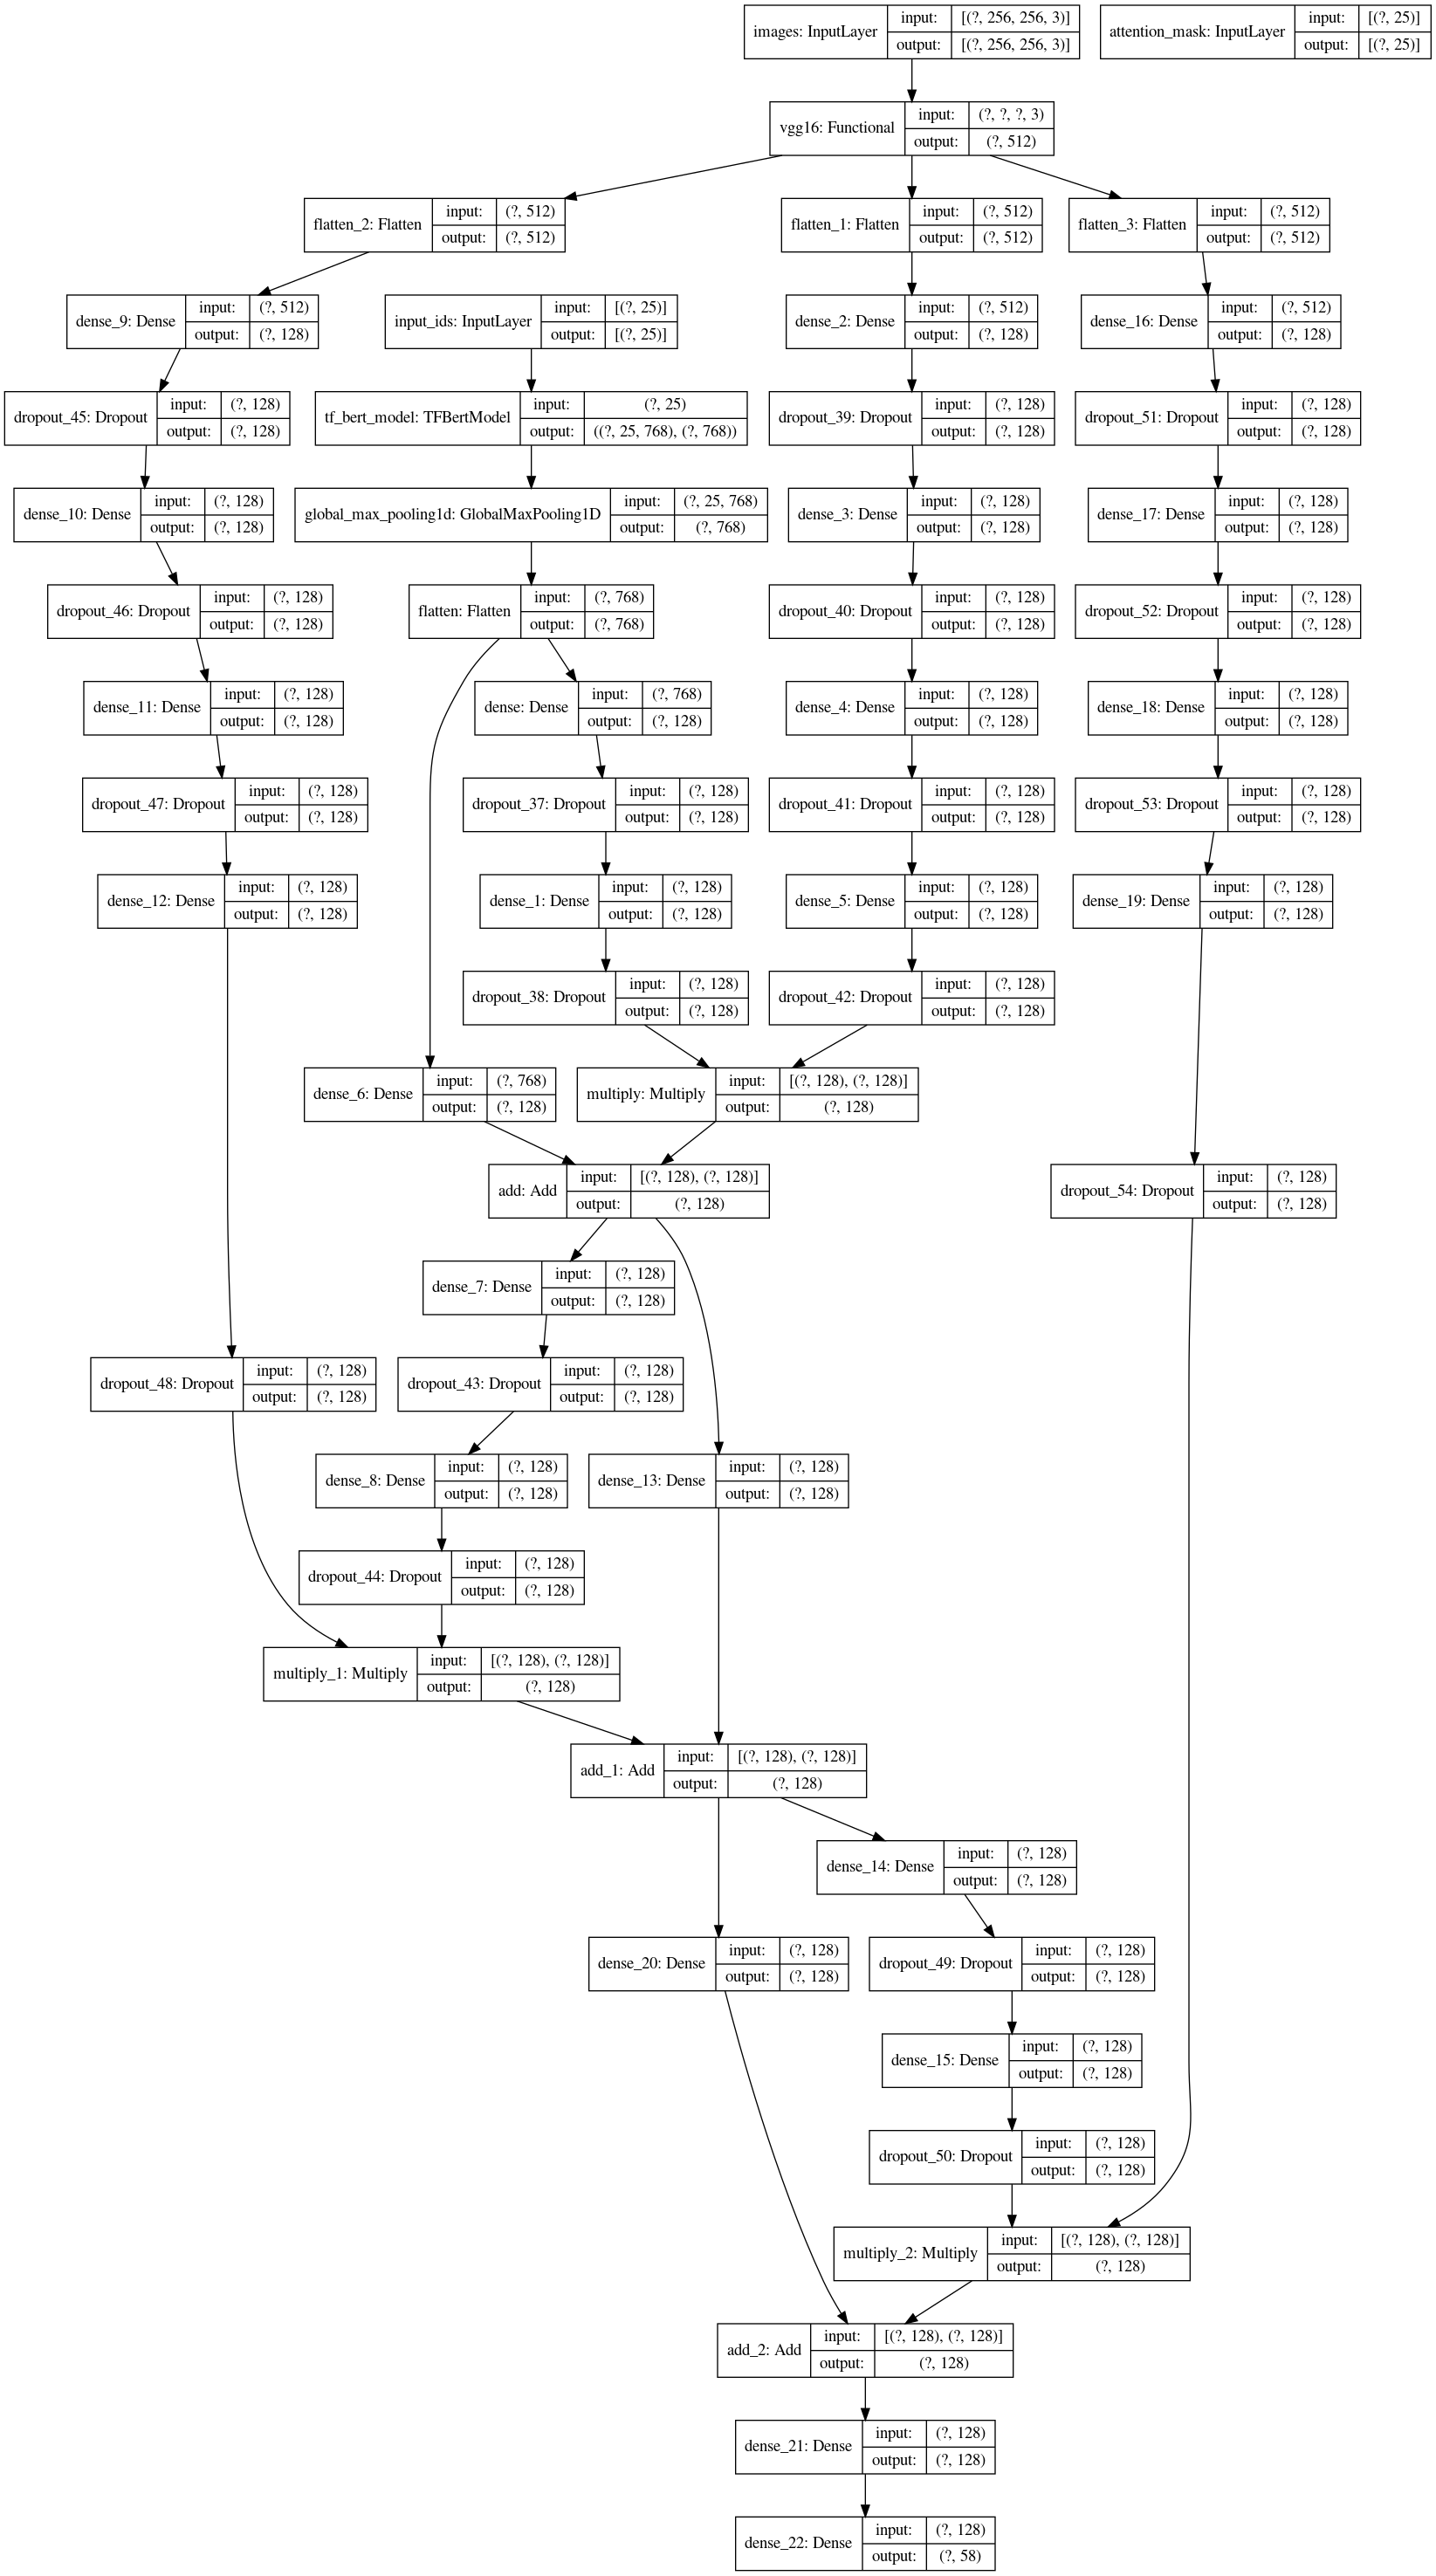

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

# Model training

In [19]:
callbacks = []

# Early Stopping
# --------------

es_callback = tf.keras.callbacks.EarlyStopping(patience=6, 
                                               monitor="val_loss",
                                              restore_best_weights = True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=3, 
                                                monitor="val_loss",
                                                verbose=1)
callbacks.append(es_callback)
callbacks.append(reduceLR)
metrics = ['accuracy']

In [20]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = metrics)

In [21]:
from tensorflow.keras.applications.vgg16 import preprocess_input

dataset = CustomDataset(num_classes = num_classes,
                        tokenizer = tokenizer,
                        max_len_question = SEQ_LEN,
                        question = train_df['question'].tolist(), 
                        filename = train_df['filename'].tolist(),
                        answer = train_df['class'].tolist(),
                        preprocessing_function = preprocess_input,
                        bs = bs
                            )

dataset_valid = CustomDataset(num_classes = num_classes,
                        tokenizer = tokenizer,
                        max_len_question = SEQ_LEN,
                        question = validation_df['question'].tolist(), 
                        filename = validation_df['filename'].tolist(),
                        answer = validation_df['class'].tolist(),
                        preprocessing_function = preprocess_input,
                        bs = bs
                             )


In [22]:
train_steps = len(dataset)
val_steps = len(dataset_valid)
model.fit_generator(generator=dataset, 
                    validation_data = dataset_valid, 
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    epochs=100,
                    verbose=1,
                    callbacks = callbacks)

Epoch 1/100
   3/2755 [..............................] - ETA: 1:29:24 - loss: 7.5435 - accuracy: 0.0417

KeyboardInterrupt: 

In [ ]:
model.save_weights('/kaggle/working/model_multiclass.h5')